In [2]:
%pylab inline
import numpy as np
import torch
import tensorflow as tf

from torch import nn 
from torch.autograd import Variable

from PIL import Image
from scipy import signal as sg

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.01, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

# References


**Convolution**

* [코넬대학교 CS1114 Section 6: Convolution](http://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf)
* [카네기멜론 Convolution and Edge Detection](http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/convolution.pdf)
* [카네기멜론 On the Origin of Deep Learning](https://arxiv.org/pdf/1702.07800.pdf)
* [유타 Spatial Filtering](http://www.coe.utah.edu/~cs4640/slides/Lecture5.pdf)
* [The Convolution Operation and CNNs](http://www.cedar.buffalo.edu/~srihari/CSE676/ConvolutionFunction.pdf)
* [Introduction to Differential Equations](https://www.math.ust.hk/~machas/differential-equations.pdf)

# Convolution

Convolution은 2개의 함수들 (e.g. $ f $ 그리고 $ g $)에 적용되는 일종의 덧셈 뺄셈과 같은 operations이며, 새로운 함수인 $ h $를 생성을 합니다. <br>
새로운 함수 $ h $는 함수 $ f $가 다른 함수 $ g $위를 지나가면서 중첩된 부분을 element-wise multiplication으로 연산뒤 각 구간별 integral을 나타냅니다.

$$ (f * g)(t) = \int^\infty_{-\infty} f(\mathcal{T}) g(t-\mathcal{T}) \ d\mathcal{T} $$

* $ f $ 는 kernel 또는 filter를 가르킴 
* $ g $ input function을 가르킴
* $ t $ signal에서는 시간을 가르키지만, 이미지 프로세싱에서는 위치를 가르킴

## Convolution을 직관적으로 이해하기

직관적으로 convolution을 이해하기 위한 코드는 아래와 같습니다.  <br>
아래의 예제에서는 이미지의 한 부분이 서로 비슷한 색상을 갖고 있으면 서로 상쇄를 시켜줘서 0값이 되지만, sharp-edge부분을 만나게 되면 색상차이가 커져서 해당 부분의 convolution값이 높아지게 됩니다. 아래에서 차의 윤곽 부분의 값이 높아진것을 알 수 있습니다. <br>
그 외에도 blur, sharpen등등 이미지를 변환시킬수 있습니다.

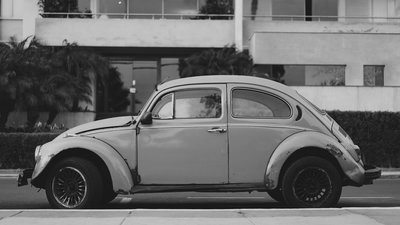

[원본 이미지] pic size: (225, 400)



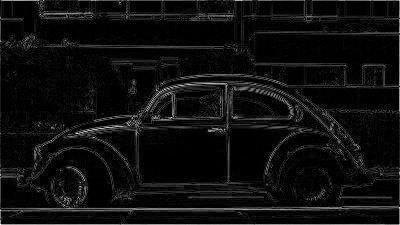

[Edge Detection] pic size:(225, 400)



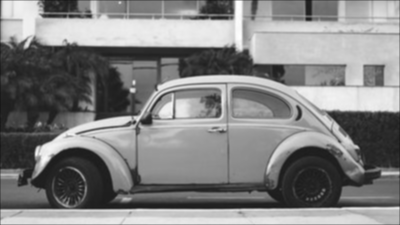

[Blur] pic size:(225, 400)



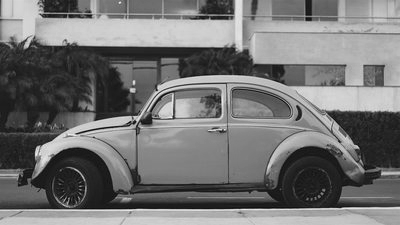

[Sharpen] pic size:(225, 400)



In [4]:
def norm(ar):
    return np.uint8(255*np.absolute(ar)/np.max(ar))

def scipy_convolve(pic, f, mode, title=None):
    h = sg.convolve2d(pic, f, mode='same')
    filtered_pic = Image.fromarray(norm(h))
    display(filtered_pic)
    print(f'[{title}] pic size:{h.shape}')
    print()

pic = Image.open('./images/car.jpg').convert('L')
display(pic)
pic = np.array(pic)
print('[원본 이미지] pic size:', pic.shape)
print()

f_edge = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])

f_blur = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]])

f_sharpen =  np.array([[0, -2, 0],
                       [-2, 256, -2],
                       [0, -2, 0]])

scipy_convolve(pic, f_edge, mode='same', title='Edge Detection')
scipy_convolve(pic, f_blur, mode='same', title='Blur')
scipy_convolve(pic, f_sharpen, mode='same', title='Sharpen')

## Convolution Operation

자세하게 보면 convolution은 다음과 같이 일어납니다. <br>
왼쪽은 input matrix, 중간은 kernel matrix, 그리고 오른쪽은 결과물입니다. <br>
아래와 같이 element-wise product를 한뒤, sum을 해줍니다. 
<img src="./images/simple_convolution_operation.png">

### [Scipy]

In [4]:
g = np.array([[22, 15, 1, 3, 60], 
              [42, 5, 38, 39, 7], 
              [28, 9, 4, 66, 79],
              [0, 2, 25, 12, 17],
              [9, 14, 2, 51,  3]], dtype='float32')
f = np.array([[0, 0, 1], 
              [0, 0, 0], 
              [1, 0, 0]], dtype='float32')
h = sg.convolve2d(g, f, mode='valid')
print(h)

[[ 29.  12.  64.]
 [ 38.  41.  32.]
 [ 13.  80.  81.]]


### [TensorFlow]

Input Tensor shape은 <span style="color:red">$ (N, H_{in}, W_{in}, C_{in}) $ </span>와 같아야 합니다.<br>
Filter 또는 kernel의 shape은 <span style="color:red">$( H_{filter}, W_{filter}, C_{in}, C_{out}) $</span> 와 같아야 합니다.

* $ N $: Batch Size
* $ H $: Height
* $ W $: Width
* $ C $: Channel (Color)


In [5]:
_g = g.reshape(-1, 5, 5, 1)
_f = f.reshape(3, 3, 1, 1)

g_tf = tf.placeholder('float32', shape=(None, None, 5, None), name='g')
f_tf = tf.placeholder('float32', shape=(3, 3, 1, 1), name='f')

conv_op = tf.nn.conv2d(g_tf, f_tf, strides=(1, 1, 1, 1), padding='VALID')
conv_op = tf.reshape(conv_op, (3, 3))

print(sess.run(conv_op, feed_dict={g_tf:_g, f_tf:_f}))

[[ 29.  12.  64.]
 [ 38.  41.  32.]
 [ 13.  80.  81.]]


### [Pytorch]

torch.nn.Conv2d의 경우 Input size는 <span style="color:red">**$ (N, C_{in}, H, W) $**</span>이어야 하며, <br>
output은 <span style="color:red">**$ (N, C_{out}, H_{out}, W_{out}) $**</span> 이며, 다음과 같은 공식을 갖습니다.

$$ \begin{array}{ll}
out(N_i, C_{out_j})  = bias(C_{out_j})
               + \sum_{{k}=0}^{C_{in}-1} weight(C_{out_j}, k)  \star input(N_i, k)
\end{array}$$

In [6]:
def create_conv(kernel, bias=None, in_channels=1, out_channels=1):
    kernel_size = kernel.shape[-1]
    kernel_ts = torch.FloatTensor(kernel)
    if bias:
        bias_ts = torch.FloatTensor(bias)
    else:
        bias_ts = torch.FloatTensor(np.zeros([1]))
    
    conv_f = torch.nn.Conv2d(1, 1, kernel_size, stride=1)
    conv_f.register_parameter('weight', torch.nn.Parameter(kernel_ts))
    conv_f.register_parameter('bias', torch.nn.Parameter(bias_ts))
    return conv_f

_g = g.reshape(-1, 1, 5, 5)
_f = f.reshape(-1, 1, 3, 3)
g_tensor = Variable(torch.FloatTensor(_g))

conv = create_conv(_f)
print(conv(g_tensor).data.numpy()[0][0])

[[ 29.  12.  64.]
 [ 38.  41.  32.]
 [ 13.  80.  81.]]
